# Custering


### Load & inspect file

In [60]:
import pandas as pd

## Load file
df = pd.read_excel("Online Retail.xlsx")


In [61]:
df.head()    



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [63]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [64]:
df[df['Quantity'] < 0].shape


(10624, 8)

In [65]:
df[df['UnitPrice'] < 0].shape

(2, 8)

In [66]:

# Drop rows with missing CustomerID 
df = df.dropna(subset=['CustomerID'])

# Remove rows with negative Quantity (returns)
df = df[df['Quantity'] > 0]

# Remove rows with negative or zero UnitPrice
df = df[df['UnitPrice'] > 0]

#Drop rows with missing Description if needed
df = df.dropna(subset=['Description'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reset index 
df.reset_index(drop=True, inplace=True)

# Preview cleaned data
print(df[df['Quantity'] < 0].shape)
print(df.isnull().sum())

(0, 9)
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [67]:
# Create a new column: Total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

### Show dataset information


In [79]:
# Check the time span of the dataset
min_date = df['InvoiceDate'].min()
max_date = df['InvoiceDate'].max()

print(f"Date range: {min_date.date()} to {max_date.date()}")

# Number of total transactions (invoices)
num_orders = df['InvoiceNo'].nunique()
print(f"Total unique orders: {num_orders}")

# Number of unique customers
num_customers = df['CustomerID'].nunique()
print(f"Number of unique customers: {num_customers}")

# Number of products
num_products = df['StockCode'].nunique()
print(f"Number of unique products: {num_products}")

# Countries represented
num_countries = df['Country'].nunique()
print(f"Number of countries: {num_countries}")

# Total revenue
total_revenue = df['TotalPrice'].sum()
print(f"Total revenue: €{total_revenue:,.2f}")


Date range: 2010-12-01 to 2011-12-09
Total unique orders: 18532
Number of unique customers: 4338
Number of unique products: 3665
Number of countries: 37
Total revenue: €8,911,407.90


In [68]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Create a Rencency, Frequency and Moentrary dataframe for k means clustering.
- This creates more smplicity while maintaining the main features of the client 

    - Activity

    - Loyalty 


    - Value

In [69]:
import datetime as dt

# Set reference date = day after the last invoice date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by customer and calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                      # Frequency
    'TotalPrice': 'sum'                                          # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# View RFM
rfm.reset_index(inplace=True)
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [70]:
from sklearn.preprocessing import StandardScaler

# Only scale the RFM columns (not CustomerID)
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Apply StandardScaler (mean = 0, std = 1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)



## Use elbow method to decide on the apppropreate amount of k-means

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

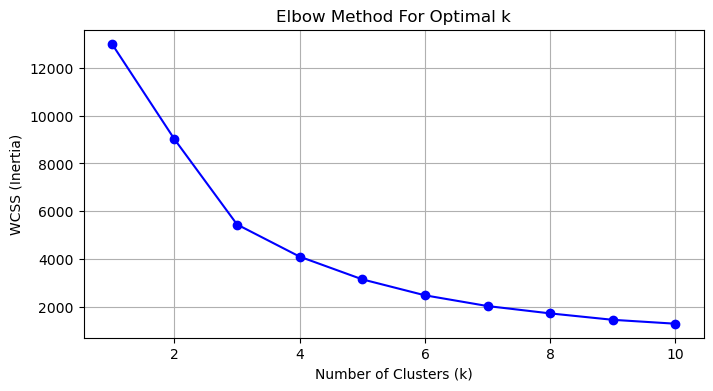

In [71]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try values of k from 1 to 10
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [72]:
# Run K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview the result
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0         248.6       1.6     478.1  1062
1          15.7      22.0   12453.2   211
2           7.4      82.5  127338.3    13
3          43.9       3.7    1350.1  3052

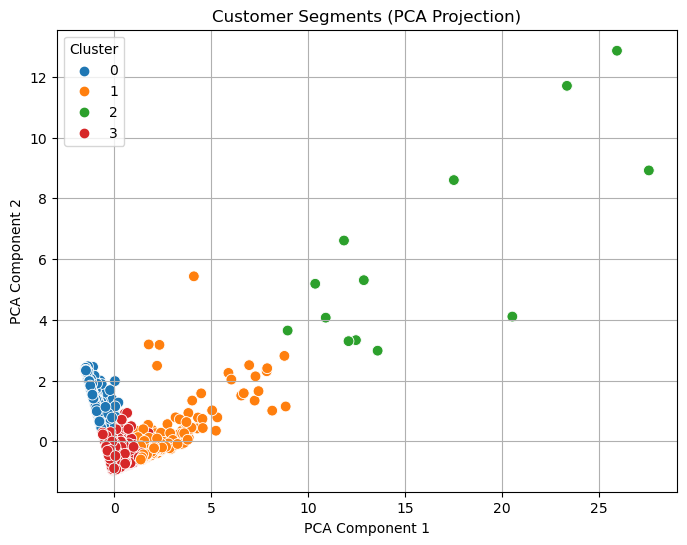

In [73]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce RFM features to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Add PCA components to the RFM table
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=60)
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [74]:
# Run K-Means with 4 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview the result
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          41.5       4.7   1855.9  3230
1           6.0      66.4  85904.4    26
2         247.1       1.6    631.4  1082

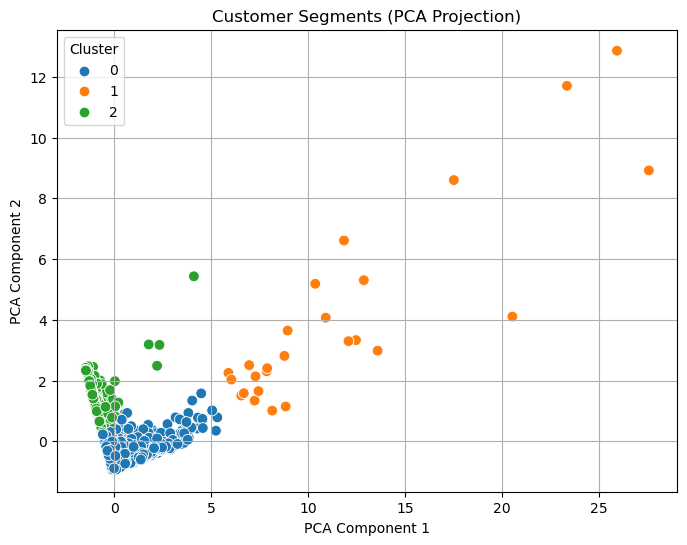

In [75]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce RFM features to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Add PCA components to the RFM table
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=60)
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


**I compared k = 3 vs. k = 4. While both showed meaningful separation, k = 4 gave more business value by identifying a rare, ultra high-value segment (Cluster 2), which would’ve been lost in k = 3.**



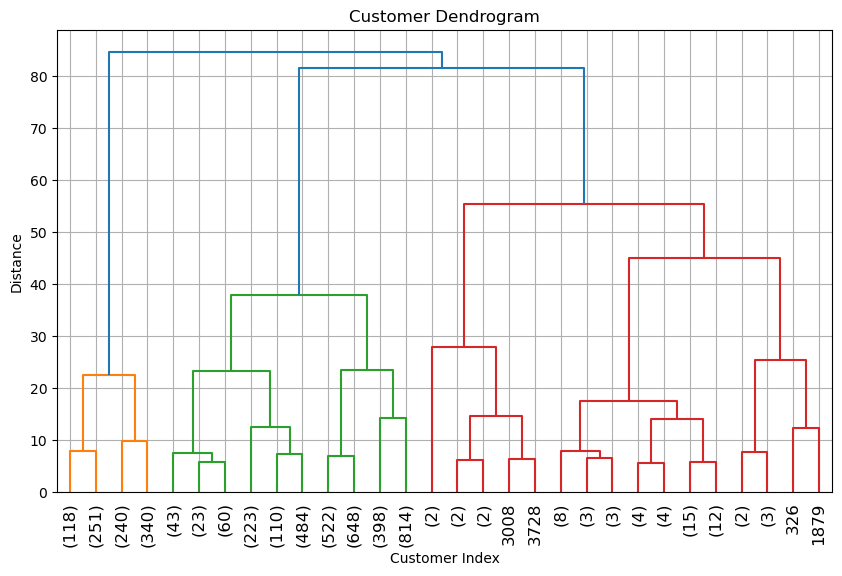

In [76]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute the linkage matrix
linked = linkage(rfm_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12.)
plt.title('Customer Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


In [77]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering with 4 clusters
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
rfm['HC_Cluster'] = hc.fit_predict(rfm_scaled)

# Group and analyze
rfm.groupby('HC_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Recency Frequency  Monetary      
              mean      mean      mean count
HC_Cluster                                  
0             24.9      43.8   31348.4    56
1             11.0      43.9  164658.5     8
2             46.2       4.3    1625.5  3325
3            259.5       1.5     457.3   949

**ALthough there are some slight differences in the exact clusters, both K-Means and Hierarchical Clustering revealed consistent patterns. The ultra-high value customers (small in number) stand out clearly, and we observe distinct dormant and mid-tier segments in both approaches**